In [3]:
import pandas as pd

df = pd.read_csv('./data_night.csv')


In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
from scipy.interpolate import Rbf
from time import strftime, localtime

def epoch2timestamp(x):
    return strftime('%H:%M:%S', localtime(x))

# Turn of interactive plotting 
plt.ioff()

BSSID = ['master',
         'EC:DA:3B:0F:5C:AC',
         '48:27:E2:AD:85:D0',
         '48:27:E2:AD:91:38']

floor_map = Image.open('./wym_floor_gradient.png')
xmax, ymax = floor_map.size

bs = 0.0

x = np.array([320, 280, 190, 250, 0, 0, xmax, xmax])
y = np.array([480, 240, 500, 40, 0, ymax, 0, ymax])

minimum = 0
maximum = max(xmax, ymax)
xi = np.linspace(0, maximum, 100)
yi = np.linspace(0, maximum, 100)

xi, yi = np.meshgrid(xi, yi)


epoch_max = max(df['Epoch'])
epoch_min = min(df['Epoch'])
tmax = max(df['Temperature'])
tmin = min(df['Temperature'])
interval = 300

epoch = epoch_min

for epoch in range(epoch_min, epoch_max, interval):

    fr = df[(df['Epoch'] >= epoch) & (df['Epoch'] <= epoch + interval)]

    z = np.array([np.mean(fr[fr['BSSID'] == BSSID[0]]['Temperature'].values),
                np.mean(fr[fr['BSSID'] == BSSID[1]]['Temperature'].values),
                np.mean(fr[fr['BSSID'] == BSSID[2]]['Temperature'].values),
                np.mean(fr[fr['BSSID'] == BSSID[3]]['Temperature'].values),
                bs, bs, bs, bs])

    z = 32 + 9/5*z

    di = Rbf(x, y, z, function='linear')

    zi = di(xi, yi)

    fig, ax = plt.subplots(1,1)

    heatmap = ax.contourf(xi, yi, zi, cmap='RdYlBu_r', vmin=32.0, vmax=75.0,
                        alpha=0.5, zorder=150, antialiased=True, levels=100)

    ax.plot(x, y, zorder=200, marker='o', markeredgecolor='black',
            markeredgewidth=0.5, linestyle='None', markersize=5, label='Sensor')

    ax.imshow(imread('./wym_floor_gradient.png')[::-1], interpolation='bicubic', zorder=1, alpha=1, origin='lower')

    fig.colorbar(heatmap, label='Degrees F')

    plt.axis('off')
    plt.legend(bbox_to_anchor=(0.55, -0.05), ncol=2)
    plt.savefig(f'./output/{epoch}.png')
    plt.close(fig)



In [35]:
import glob

import cv2

folder = './output'

frames = [Image.open(image) for image in glob.glob(f'{folder}/*.png')]

frames[0].save('animation.gif', format='GIF', append_images=frames, save_all=True, duration=100, loop=0)

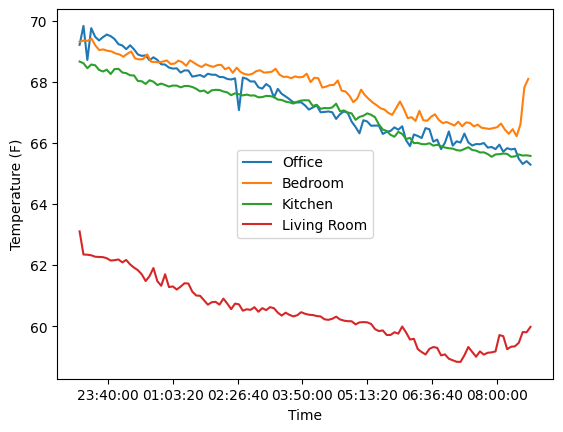

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np
from time import strftime, localtime

def epoch2timestamp(x, _):
    return strftime('%H:%M:%S', localtime(x))

def moving_average(x, w, F=True):
    return 32 + ((9 / 5) * (np.convolve(x, np.ones(w), 'same') / w))

BSSID = ['master',
         'EC:DA:3B:0F:5C:AC',
         '48:27:E2:AD:85:D0',
         '48:27:E2:AD:91:38']

sensor_0 = df[df['BSSID'] == BSSID[0]]
sensor_1 = df[df['BSSID'] == BSSID[1]]
sensor_2 = df[df['BSSID'] == BSSID[2]]
sensor_3 = df[df['BSSID'] == BSSID[3]]

fig, ax = plt.subplots(1, 1)
ax.plot(sensor_0['Epoch'][50:-50:300], moving_average(sensor_0['Temperature'], 50)[50:-50:300], label='Office')
ax.plot(sensor_1['Epoch'][50:-50:300], moving_average(sensor_1['Temperature'], 50)[50:-50:300], label='Bedroom')
ax.plot(sensor_2['Epoch'][50:-50:300], moving_average(sensor_2['Temperature'], 50)[50:-50:300], label='Kitchen')
ax.plot(sensor_3['Epoch'][50:-50:300], moving_average(sensor_3['Temperature'], 50)[50:-50:300], label='Living Room')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature (F)')

ax.xaxis.set_major_formatter(epoch2timestamp)
ax.legend()

plt.show()